In [4]:
import sys
import getopt
import math
import numpy as np
from netCDF4 import Dataset as NC
import matplotlib.pyplot as plt
import tqdm
from scipy import ndimage
from scipy import spatial
from copy import copy
import subprocess
from funcs import *
import copy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [6]:
from IPython.display import display, Javascript
import time
import hashlib

def save_and_commit(notebook_path, branch_name, nc_file, commit_message):
    
    current_branch = subprocess.check_output(["git", "rev-parse", "--abbrev-ref", "HEAD"]).decode('ascii').strip()
    if current_branch != branch_name:
        raise ValueError('not on correct branch')
    
    start_md5 = hashlib.md5(open(notebook_path,'rb').read()).hexdigest()
    display(Javascript('IPython.notebook.save_checkpoint();'))
    current_md5 = start_md5
        
    while start_md5 == current_md5:
        time.sleep(1)
        current_md5 = hashlib.md5(open(notebook_path,'rb').read()).hexdigest()
            
    hashmark =  subprocess.check_output(['git', 'rev-parse', 'HEAD']).decode('ascii').strip()
    
    save_model = ["cp", "".format(nc_file), "./models/{}.nc".format(hashmark)]
    stage = ["git", "add", "{}".format(notebook_path)]
    commit = ["git", "commit", "-m", commit_message]
    try:
        proc = subprocess.check_output(stage, stderr=subprocess.STDOUT)
        proc = subprocess.check_output(commit, stderr=subprocess.STDOUT)
        proc = subprocess.check_output(save_model, stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError:
        raise ValueError('something went wrong')

In [2]:
filename = "icecap_conf.nc"
nc = NC(filename, 'w', format="NETCDF3_CLASSIC")
var = nc.createVariable("pism_overrides", 'i')

attrs = {"ocean.always_grounded": "no",
         "geometry.update.use_basal_melt_rate": "no",
         "stress_balance.ssa.compute_surface_gradient_inward": "no",
         "flow_law.isothermal_Glen.ice_softness": 1.0e-25,
         "constants.ice.density": 900.,
         "constants.sea_water.density": 1000.,
         "bootstrapping.defaults.geothermal_flux": 0.0,
         "stress_balance.ssa.Glen_exponent": 3.,
         "constants.standard_gravity": 9.81,
         "ocean.sub_shelf_heat_flux_into_ice": 0.0,
         "stress_balance.sia.bed_smoother.range": 0.0,
         }

for name, value in attrs.items():
    var.setncattr(name, value)

nc.close()

In [3]:
WRIT_FILE = 'icecap_initialSetup.nc'

### CONSTANTS ###

secpera = 31556926.
ice_density = 910.0             # [kg m-3]

Lx = 2 * 25e3  # in km
Ly = 2 * 25e3  # in km

dx, dy = 1e3,1e3

# grid size: # of boxes

ny = int(np.floor(Lx / dx) + 1)  # make it an odd number
nx = int(np.floor(Ly / dy) + 1)  # make it an odd number

# grid size: extent in km's, origin (0,0) in the center of the domain

x = np.linspace(-Lx, Lx, nx)
y = np.linspace(-Ly, Ly, ny)

nxcenter = int(np.floor(0.5 * nx))
nycenter = int(np.floor(0.5 * ny))

surf = np.ones((ny, nx))
topg = np.zeros((ny, nx))
ice_surface_temp = np.ones((ny, nx))*268.15
precip = np.zeros((ny, nx))
land_ice_area_fraction_retreat = np.ones_like(topg)


for i in range(0, nx):
    for j in range(0, ny):
        dist = ((x[i])**2+(y[j])**2)**0.5
        dist2a=((x[i]-Lx/5)**2+(y[j]-Ly/5)**2)**0.5
        dist2b=((x[i]+Lx/5)**2+(y[j]+Ly/5)**2)**0.5
        dist2c = ((2*(x[i])+Lx/5)**2+(2*(y[j])-Ly/5)**2)**0.5
        dist2d = ((2*(x[i])-Lx/5)**2+(2*(y[j])+Ly/5)**2)**0.5
        # add 10k to topography to prevent floating ice
        topg[i, j] = 10000 + np.maximum(500*(1-dist2a*5/Lx),0)+np.maximum(500*(1-dist2b*5/Lx),0)+np.maximum(500*(1-dist2c*5/Lx),0)+np.maximum(500*(1-dist2d*5/Lx),0)
        precip[i, j] = 5 *(1-(dist*2/Lx))
        surf[i,j] = topg[i,j]+1

thk = surf-topg

##### define variables, set attributes, write data #####
# format: ['units', 'long_name', 'standard_name', '_FillValue', array]

vars = {'y':    ['m',
                 'y-coordinate in Cartesian system',
                 'projection_y_coordinate',
                 None,
                 y],
        'x':    ['m',
                 'x-coordinate in Cartesian system',
                 'projection_x_coordinate',
                 None,
                 x],
        'thk':  ['m',
                 'floating ice shelf thickness',
                 'land_ice_thickness',
                 1.0,
                 thk],
        'topg': ['m',
                 'bedrock surface elevation',
                 'bedrock_altitude',
                 0.0,
                 topg],
        'ice_surface_temp': ['K',
                             'annual mean air temperature at ice surface',
                             'surface_temperature',
                             268.0,
                             ice_surface_temp],
        'climatic_mass_balance': ['kg m-2 year-1',
                                  'mean annual net ice equivalent accumulation rate',
                                  'land_ice_surface_specific_mass_balance_flux',
                                  0.2 * ice_density,
                                  precip * ice_density],
        'land_ice_area_fraction_retreat' : ["1",
                                            "maximum ice extent mask",
                                            "",
                                            -1,
                                            land_ice_area_fraction_retreat]
        }

##### define dimensions in NetCDF file #####
def create_nc_input(vars, WRIT_FILE):
    ncfile = NC(WRIT_FILE, 'w', format='NETCDF3_CLASSIC')
    xdim = ncfile.createDimension('x', nx)
    ydim = ncfile.createDimension('y', ny)
    
    for name in list(vars.keys()):
        [_, _, _, fill_value, data] = vars[name]
        if name in ['x', 'y']:
            var = ncfile.createVariable(name, 'f4', (name,))
        else:
            var = ncfile.createVariable(name, 'f4', ('y', 'x'), fill_value=fill_value)
        for each in zip(['units', 'long_name', 'standard_name'], vars[name]):
            if each[1]:
                setattr(var, each[0], each[1])
        var[:] = data
    
    # finish up
    ncfile.close()
    print("NetCDF file ", WRIT_FILE, " created")
    print('')
    
create_nc_input(vars, WRIT_FILE)

NetCDF file  icecap_initialSetup.nc  created



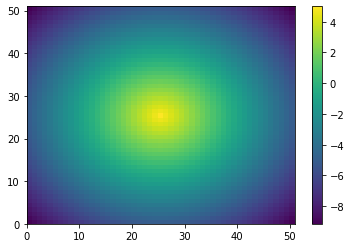

In [4]:
fig, axes = plt.subplots()
colors = plt.pcolor(precip, axes=axes)
fig.colorbar(colors)

In [5]:
def create_script(forward_or_iteration):
    print("""#!/bin/bash
    ###### run script for experiment icecap ######""")
    print('# build the PISM command')
    print('set -e #exit on error')
    print('')
    print('NN="$1"')
    print('CLIMATEFILE="$2"')
    print('DURATION=$3')
    print('OUTNAME=$4')
    print('OPT5=$5')
    print('RUNTIME="-ys 0 -ye $DURATION"')
    
    print('')
    print('CLIMATE="-surface given -surface_given_file $CLIMATEFILE"')
    print('grid="-Mx 51 -My 51 -Mz 30 -Mbz 1 -Lz 20000 -Lbz 1 -grid.recompute_longitude_and_latitude false"')
    print('PHYS="-stress_balance ssa+sia -ssa_flow_law isothermal_glen"')
    print('THERMAL="-energy none"')
    print('CONF="-config_override icecap_conf.nc"')

    
    # power law sliding relation t_b=-C*|u|^(m-1)*u --> doesn't require thermal model
    print('SLIDING="-pseudo_plastic -pseudo_plastic_q 0.33333 -pseudo_plastic_uthreshold 3.1556926e7 -yield_stress constant -tauc 10e7"')
    
    print('echo')
    print('echo "# ======================================================================="')
    print('echo "# create icecap"')
    print('echo "#  $NN processors, $DURATION a run, 50 km grid, $CLIMATEFILE, $4"')
    print('echo "# ======================================================================="')
    
    print('')
    print('PISM_MPIDO="mpiexec -n "')
    
    print('')
    print('PISM_BIN=/home/thomas/pism/bin')
    print('PISM_EXEC="pismr"')
    print('EXVARS="diffusivity,temppabase,tempicethk_basal,velsurf_mag,mask,thk,usurf,velbase_mag, uvel, vvel"')
    
    print('')
    print('PISM="${PISM_BIN}/${PISM_EXEC}"')
    
    print('')
    print('EXSTEP=100')
    print('TSNAME=ts_$OUTNAME')
    print('TSTIMES=0:yearly:$DURATION')
    print('EXNAME=ex_$OUTNAME')
    print('EXTIMES=0:$EXSTEP:$DURATION')
    print('DIAGNOSTICS="-ts_file $TSNAME -ts_times $TSTIMES -extra_file $EXNAME -extra_times $EXTIMES -extra_vars $EXVARS"')
    
    print('DIAGNOSTICS_ITER="-save_file s_$OUTNAME -save_times $OPT5 -save_force_output_times"')

    
    print('')
    if forward_or_iteration == 'forward':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE -bootstrap ${grid} $SLIDING $THERMAL $CONF $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS -o $OUTNAME"')
    elif forward_or_iteration == 'iteration':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE $CONF $DIF $ENHANCE $SLIDING $THERMAL $OCEAN $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS_ITER -o $OUTNAME"')
    
    print('')
    print('echo')
    print('$cmd')

In [6]:
original_stdout = sys.stdout # Save a reference to the original standard output
with open('icecap_build_script.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    create_script('forward')
    sys.stdout = original_stdout # Reset the standard output to its original value
    f.close()

In [7]:
!chmod +x icecap_build_script.sh
!./icecap_build_script.sh 4 icecap_initialSetup.nc 15000 icecap_output.nc > icecap_output_log.txt

In [5]:
!tail icecap_output_log.txt

vy$Eh  diffusivity (overrides reporting (-extra_times)) (dt=0.76669)
S    14998.904:    0.00481    0.01040          0.01985     11.35858
  SSA:     6 outer iterations, ~17.0 KSP iterations each
vy$Eh  diffusivity (overrides reporting (-extra_times)) (dt=0.76669)
S    14999.670:    0.00481    0.01040          0.01985     12.29812
  SSA:     8 outer iterations, ~16.5 KSP iterations each
vy$Eh  reporting (-extra_times) (overrides end of the run) (dt=0.32975)
S    15000.000:    0.00481    0.01040          0.01985     11.32802
... done with run
Writing model state to file `icecap_output.nc'...


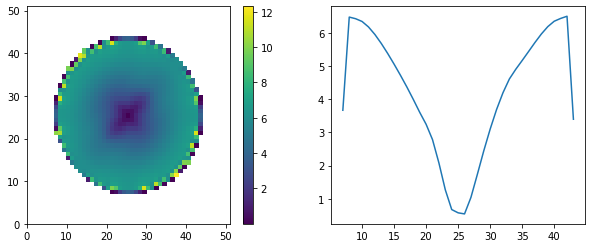

In [6]:
### check netCDF output ###
def get_nc_data(file, var, time):
    ds = NC(file)
    avail_vars = [nc_var for nc_var in ds.variables]
    if var not in avail_vars:
        raise ValueError('variable not found; must be in {}'.format(avail_vars))
    else:
        var_data = ds[var][time][:]
    return var_data
    
def plots(nrow=1, ncol=2, size=(10,4)):
    fig, axes = plt.subplots(nrow, ncol, figsize=size)
    return fig, axes

## shifted dhdt-field
from scipy.interpolate import griddata

def shift(data, u, v, dx):
    x_shift, y_shift = np.meshgrid(range(nx), range(ny))
    uv_mag = np.ones_like(u)
    uv_mag[np.logical_or(u!=0, v!=0)] = np.sqrt(u[np.logical_or(u!=0, v!=0)]**2+v[np.logical_or(u!=0, v!=0)]**2)
    x_shift = x_shift+(u/uv_mag)*dx
    y_shift = y_shift+(v/uv_mag)*dx

    points = np.zeros((np.shape(u)[0]*np.shape(u)[1],2))
    points[:,0] = x_shift.flatten()
    points[:,1]=y_shift.flatten()
    xi, yi = np.meshgrid(range(nx), range(ny))

    newgrid = griddata(points, data.flatten(), (xi.flatten(), yi.flatten())).reshape(np.shape(u))
    return newgrid

nc_data = get_nc_data('ex_icecap_output.nc', 'velbase_mag', -1)
nc_data2 = get_nc_data('ex_icecap_output.nc', 'thk', -2)
fig, axes = plots()
colors = axes[0].pcolor(nc_data)
fig.colorbar(colors, ax=axes[0])
axes[1].plot(range(nx), nc_data[26,:])

In [184]:
### bed recovery ###
S_ref = get_nc_data('icecap_output.nc', 'usurf', 0)
S_rec = copy.deepcopy(S_ref)

h_ref = get_nc_data('icecap_output.nc', 'thk', 0)
B_rec = copy.deepcopy(S_ref)#np.zeros_like(topg)+10000
dh_ref = np.zeros_like(topg)#nc_data - nc_data2
B_init = copy.deepcopy(B_rec)
mask = get_nc_data('icecap_output.nc', 'mask', 0)/2

B_rec_all = []
dh_all = []
B_misfit_vs_iter=[]
dh_misfit_vs_iter=[]
misfit_all = []
S_rec_all = []

pmax = 3000
dt = 0.1
beta = 1
bw = 4

!cp icecap_output.nc icecap_iteration_out.nc
    
original_stdout = sys.stdout
with open('icecap_iteration_script.sh', 'w') as f:
    sys.stdout = f
    create_script('iteration')
    sys.stdout = original_stdout
    f.close()
!cp icecap_iteration_out.nc icecap_iteration_in.nc
#!chmod +x icecap_iteration_script.sh

In [185]:
for p in tqdm.trange(0, pmax):
    
    h_old = S_rec - B_rec
    
    !cp icecap_iteration_out.nc icecap_iteration_in.nc
    #if p>0:
    #    mask = get_nc_data('icecap_iteration_in.nc', 'mask', 0)
    #    k = np.ones((bw+2, bw+2))
    #    buffer = ndimage.convolve(mask, k)/(bw+2)**2/2
    #    buffer[buffer>=.5] = 0
    #    buffer[buffer!=0] = (buffer[buffer!=0])*2
    #    B_rec -= (buffer) * np.mean(h_old) 
    #    h_old = S_ref - B_rec

    nc_updated = NC('icecap_iteration_in.nc', 'r+')
    nc_updated['topg'][0,:,:]=B_rec
    nc_updated['thk'][0,:,:]=h_old
    #nc_updated['climatic_mass_balance'][0,:,:]=np.maximum(nc_updated['climatic_mass_balance'][0:,:],0)
    nc_updated.close()
        
    cmd = ["./icecap_iteration_script.sh", '4', 'icecap_iteration_in.nc', str(dt), 'icecap_iteration_out.nc', str(dt/2)]
    subprocess.call(cmd, stdout=open('icecap_iteration_log.txt', 'a'))
    
    h_rec = get_nc_data('icecap_iteration_out.nc', 'thk', 0)
    dh_rec = (h_rec - h_old)/dt
    
    mask_iter = get_nc_data('icecap_iteration_out.nc', 'mask', 0)/2 #base buffer on ice mask produced by PISM --> faster than loop
    k = np.ones((bw, bw))
    buffer = ndimage.convolve(mask_iter, k)/(bw)**2 #smooth ice mask...
    criterion = np.logical_and(np.logical_and(buffer > 0, buffer != 1), mask==1)

    u = get_nc_data('icecap_iteration_out.nc', 'uvelsurf', 0)
    u[criterion] = 0
    v = get_nc_data('icecap_iteration_out.nc', 'vvelsurf', 0)
    v[criterion] = 0
    
    misfit = shift((dh_rec-dh_ref), u, v, .3)
    #misfit = dh_rec - dh_ref
    
    #misfit_lowpass = ndimage.gaussian_filter(misfit, 1)
    #misfit_highpass = misfit - misfit_lowpass
    
    B_rec = B_rec - beta * (misfit)
    #S_rec[np.logical_and(mask==1, h_rec>20)] += (beta*.05) * misfit_highpass[np.logical_and(mask==1, h_rec>20)] 
    S_rec[np.logical_and(mask==1, h_rec>20)] += (beta*0.02) * misfit[np.logical_and(mask==1, h_rec>20)] 

    '''

    H_rec = S_ref - B_rec
    B_rec = ndimage.gaussian_filter(H_rec, 1, truncate=1)
    B_rec = S_ref - H_rec
    ### buffer ###
    h_inpaint = S_rec - B_rec
    h_inpaint[criterion] = np.nan #...and take those values in the transition between ice and no ice;
    h_inpaint = inpaint_nans(h_inpaint)
    B_rec = S_rec - h_inpaint
    ### buffer end ###
    '''
    #indices = ndimage.distance_transform_edt(np.isnan(B_rec), sampling=3,return_distances=False, return_indices=True)
    #B_rec = B_rec[tuple(indices)]
    
    #if p>0:
    #    B_rec += buffer*np.mean(h_old)
#    mask = get_nc_data('icecap_iteration_out.nc', 'mask', 0)
#    k = np.ones((bw, bw))
#    buffer = ndimage.convolve(mask, k)/(bw)**2/2
    #buffer[buffer<.5] = 0
    #buffer[buffer!=0] = (buffer[buffer!=0]-1)*2
    
    #buffer[buffer<=-.5]=0#(buffer[buffer>=.5]-1)
    #buffer[buffer>=.25]=(buffer[buffer>=.25]-.5)
    #buffer[buffer!=0]=-(buffer[buffer!=0]-.25)
#    buffer_infill = copy(buffer)
#    buffer_infill[np.logical_and(buffer_infill!=0, buffer_infill !=1)] = np.nan
    #B_rec[np.where(np.isnan(buffer_infill))] = 10000
#    buffer_infill = (buffer_infill+.1)/(buffer_infill+.1)
#    h_rec = inpaint_nans((S_ref-B_rec)*buffer_infill)
#    B_rec = S_ref-h_rec
#    #B_rec += (buffer) * np.max(dh_rec) * ((B_rec-10000)/abs(B_rec-10000))
    #B_rec += np.maximum(-(buffer - 1) * B_init, B_rec * buffer)

    B_rec[B_rec>S_ref]=S_ref[B_rec>S_ref]
    B_rec[B_rec>S_rec]=S_rec[B_rec>S_rec]
    B_rec[mask==0] = S_ref[mask==0]
    S_rec[mask==0] = S_ref[mask==0]
    B_rec_all.append(B_rec)
    dh_all.append(dh_rec)
    S_rec_all.append(S_rec)
    
    B_misfit_vs_iter.append(np.mean(abs(B_rec[mask==1]-topg[mask==1])))
    dh_misfit_vs_iter.append(np.mean(abs(dh_rec[mask==1]-dh_ref[mask==1])))
    misfit[mask==0] = np.nan
    misfit_all.append(misfit)

  0%|          | 0/3000 [00:00<?, ?it/s]<ipython-input-7-cc3cbaec7366>:21: RuntimeWarning: invalid value encountered in sqrt
  uv_mag[np.logical_or(u!=0, v!=0)] = np.sqrt(u[np.logical_or(u!=0, v!=0)]**2+v[np.logical_or(u!=0, v!=0)]**2)
100%|██████████| 3000/3000 [50:05<00:00,  1.00s/it]


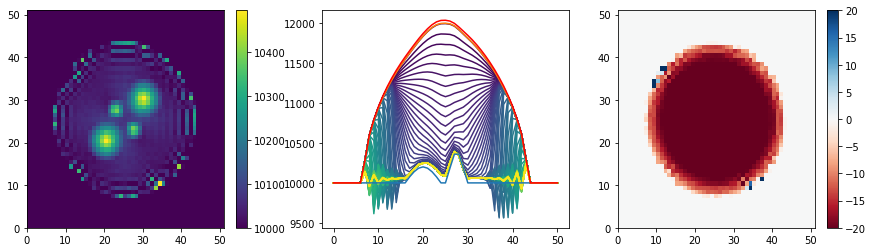

In [84]:
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(B_rec_all))]
fig, axes = plt.subplots(1,3, figsize=(15,4))
field = axes[0].pcolor(B_rec_all[-1], vmin=10000)
fig.colorbar(field, ax=axes[0])
for i in range(0,len(B_rec_all),30):
    lines = axes[1].plot(range(nx), B_rec_all[i][:,23], color=colors[i])
lines1 = axes[1].plot(range(nx), topg[:,23])
lines2 = axes[1].plot(range(nx), S_ref[:,23])
lines3 = axes[1].plot(range(nx), S_rec[:,23], 'r')
lines4 = axes[2].pcolor(S_ref - S_rec, cmap='RdBu', vmin=-20, vmax=20)
fig.colorbar(lines4, ax = axes[2])

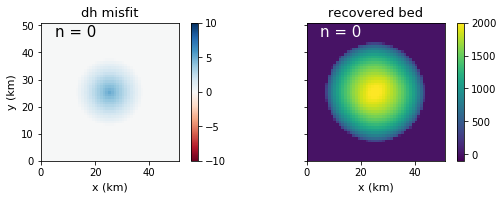

In [81]:
import itertools
import matplotlib.animation as animation

zmin = -10
zmax = 10
kw_dh = dict(cmap=plt.cm.RdBu, vmin=zmin, vmax=zmax)
kw_B = dict(cmap=plt.cm.viridis, vmin = -100, vmax=2000)

fig,ax = plt.subplots(1,2, figsize=(8,3), sharey=True)
field = ax[0].pcolor(dh_all[0], **kw_dh)
cbar = plt.colorbar(field, ax = ax[0])
ax[0].set_aspect('equal', 'box')

field = ax[1].pcolor(B_rec_all[1], **kw_B)
cbar = plt.colorbar(field, ax = ax[1])
ax[1].set_aspect('equal', 'box')

ax[0].set_ylabel('y (km)', fontsize=11)
ax[0].set_xlabel('x (km)', fontsize=11)
ax[1].set_xlabel('x (km)', fontsize=11)

def animate_dh(index):
    ax[0].clear()
    ax[0].pcolor(dh_all[index], **kw_dh)
    ax[0].text(.1,.9,'n = {}'.format(index), transform = ax[0].transAxes, fontsize=15)
    ax[0].set_title('dh misfit', fontsize=13)
    ax[0].set_aspect('equal', 'box')
    ax[0].set_xlabel('x (km)', fontsize=11)
    ax[0].set_ylabel('y (km)', fontsize=11)

    ax[1].clear()
    ax[1].pcolor(B_rec_all[index]-10000, **kw_B)
    ax[1].text(.1,.9,'n = {}'.format(index), transform = ax[1].transAxes, fontsize=15, color='white')
    ax[1].set_title('recovered bed', fontsize=13)
    ax[1].set_aspect('equal', 'box')
    ax[1].set_xlabel('x (km)', fontsize=11)

ani = animation.FuncAnimation(fig,animate_dh,range(0,len(dh_all), 15),interval=100,blit=False)

plt.tight_layout(rect=(0,0,1,.9), w_pad = .2)
plt.show()
ani.save('icecap_misfit_bed_animation.mp4', dpi = 300)

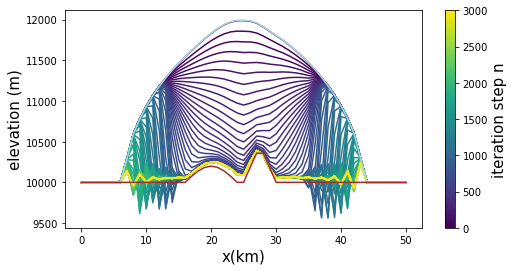

In [105]:
from matplotlib import colors as plt_colors

colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(B_rec_all))]
bounds=np.linspace(0,len(B_rec_all), 1000)
norm = plt_colors.BoundaryNorm(bounds, colormap.N)

fig, axes = plt.subplots(figsize=(8,4))
for i in range(0,len(B_rec_all),30):
    lines = axes.plot(range(nx), B_rec_all[i][:,23], color=colors[i])
lines2 = axes.plot(range(nx), S_ref[:,23], color = 'lightblue')
lines1 = axes.plot(range(nx), topg[:,23], color='brown')
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax = axes, ticks=[0,500, 1000, 1500, 2000, 2500, 3000])
cbar.set_label('iteration step n', fontsize= 15)
axes.set_xlabel('x(km)', fontsize= 15)
axes.set_ylabel('elevation (m)', fontsize= 15)
plt.savefig('./figures/icecap_crosssection.png', dpi = 400)

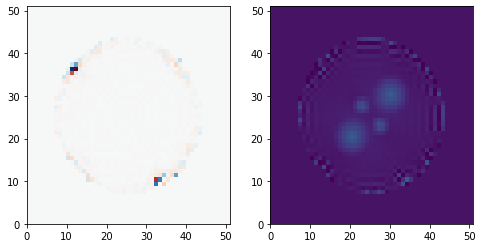

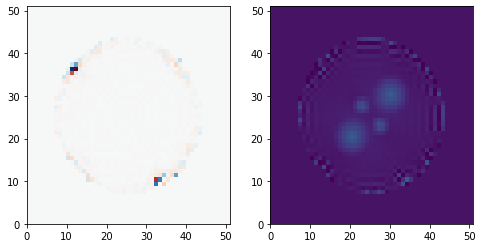

In [9]:
from IPython.display import display, clear_output
fig, axes = plt.subplots(1,2,figsize=(8,4))
for i in range(0,len(B_rec_all),1000):
    field = axes[0].pcolor(dh_all[i], cmap='RdBu', vmin=-10, vmax=10)
    field = axes[1].pcolor(B_rec_all[i], vmin = 9900, vmax = 12000)
    #fig.colorbar(field, ax=axes[0])
    clear_output(wait=True)
    display(fig)

In [1]:
import shelve

bk_restore = shelve.open('./it3000_beta1_dt.1_fromsurf_tosurf.02')
if len(bk_restore) == 0:
    bk_restore.close()
    raise ValueError('nothing inside file or file does not exist')

for k in bk_restore:
    try:
        globals()[k] = bk_restore[k]
    except:
        print('Warning: {} could not be restored'.format(k))
        continue
bk_restore.close()

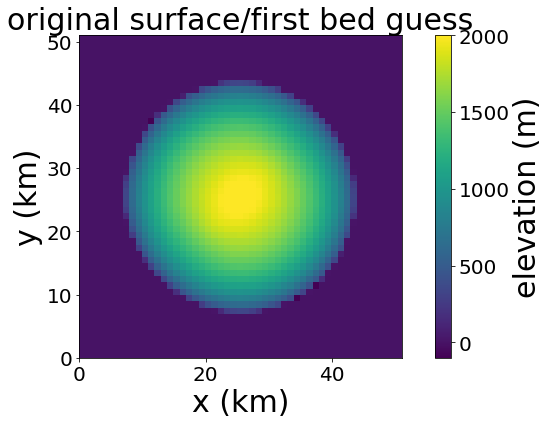

In [112]:
fig, ax = plt.subplots(figsize=(10,6))
field = plt.pcolor(S_rec-10000, vmin = -100, vmax= 2000)
cbar = fig.colorbar(field, ax = ax)
ax.set_aspect('equal', 'box')
ax.set_xlabel('x (km)', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel('y (km)', fontsize=30)
ax.set_title('original surface/first bed guess', fontsize=30)
#ax.set_title('original bed', fontsize=30)
cbar.set_label('elevation (m)', fontsize=30)
cbar.ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_facecolor((1.0, 1, 1))
plt.tight_layout()

plt.savefig('./figures/S_ref.png', dpi=800)

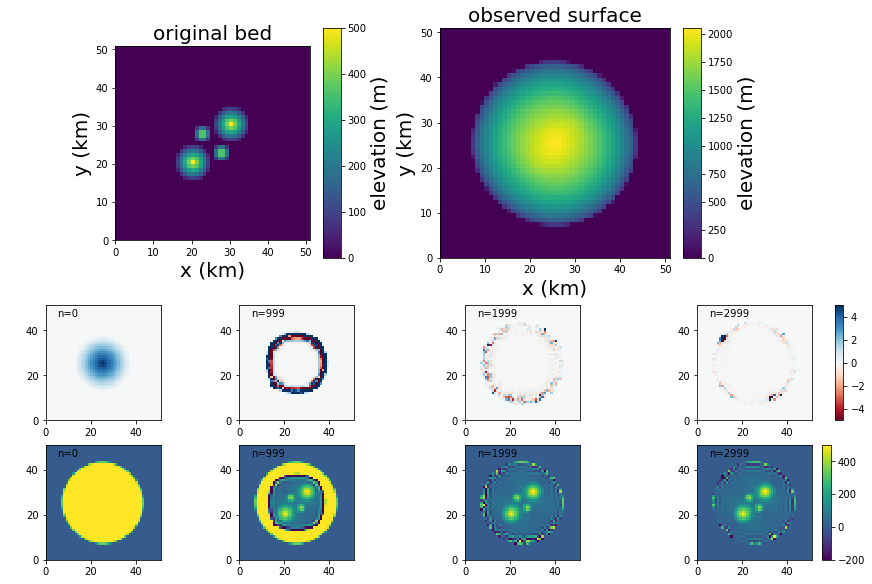

In [10]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(constrained_layout=True, figsize=(12,8))

fs = 20
ls = 10

gs = GridSpec(8, 12, figure=fig)
ax = [None] * 10
ax[0] = fig.add_subplot(gs[0:4, 1:5])
ax[1] = fig.add_subplot(gs[0:4, 6:11])

ax[2] = fig.add_subplot(gs[4:6, 0:3])
ax[3] = fig.add_subplot(gs[4:6, 3:6])
ax[4] = fig.add_subplot(gs[4:6, 6:9])
ax[5] = fig.add_subplot(gs[4:6, 9:12])
ax[6] = fig.add_subplot(gs[6:8, 0:3])
ax[7] = fig.add_subplot(gs[6:8, 3:6])
ax[8] = fig.add_subplot(gs[6:8, 6:9])
ax[9] = fig.add_subplot(gs[6:8, 9:12])

field1 = ax[0].pcolor(topg-10000)
cbar1 = fig.colorbar(field1, ax = ax[0])
ax[0].set_aspect('equal', 'box')
ax[0].set_xlabel('x (km)', fontsize=fs)
ax[0].tick_params(axis='both', which='major', labelsize=ls)
ax[0].set_ylabel('y (km)', fontsize=fs)
ax[0].set_title('original bed', fontsize=fs)
cbar1.set_label('elevation (m)', fontsize=fs)
cbar1.ax.tick_params(axis='both', which='major', labelsize=ls)

field2 = ax[1].pcolor(S_ref-10000)
cbar2 = fig.colorbar(field2, ax = ax[1])
ax[1].set_aspect('equal', 'box')
ax[1].set_xlabel('x (km)', fontsize=fs)
ax[1].tick_params(axis='both', which='major', labelsize=ls)
ax[1].set_ylabel('y (km)', fontsize=fs)
ax[1].set_title('observed surface', fontsize=fs)
cbar2.set_label('elevation (m)', fontsize=fs)
cbar2.ax.tick_params(axis='both', which='major', labelsize=ls)

for i in range(4):
    field3 = ax[i+2].pcolor(dh_all[int((pmax-1)/3*i)], cmap='RdBu', vmin=-5, vmax=5)
    ax[i+2].set_aspect('equal', 'box')
    ax[i+2].text(.1, .9, 'n={}'.format(int((pmax-1)/3*i)), transform = ax[i+2].transAxes)

cbar3 = fig.colorbar(field3, ax = ax[5])

    
for i in range(4):
    field4 = ax[i+6].pcolor(B_rec_all[int((pmax-1)/3*i)]-10000, vmin = -200, vmax = 500)
    ax[i+6].set_aspect('equal', 'box')
    ax[i+6].text(.1, .9, 'n={}'.format(int((pmax-1)/3*i)), transform = ax[i+6].transAxes)

cbar4 = fig.colorbar(field4, ax = ax[9])

#plt.savefig('./icecap_panel.svg')

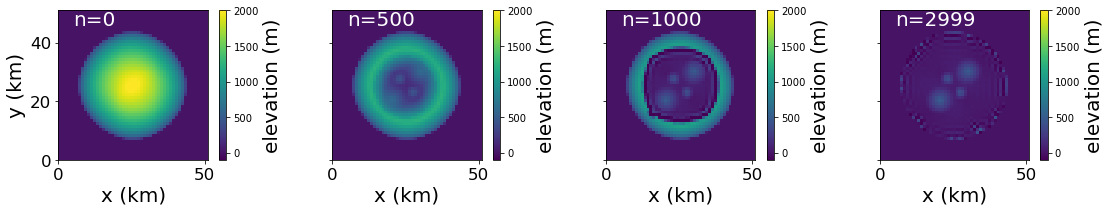

In [17]:
#B_rec_all = B_rec_alls[1]
#dh_all = dh_alls[1]
fig, ax = plt.subplots(1,4, figsize=(16,3), sharey=True)
for q,i in enumerate([0,500,1000,2999]):
    #field3 = ax[q].pcolor(dh_all[i], vmin=-5, vmax=5, cmap='RdBu')
    field3 = ax[q].pcolor(B_rec_all[i]-10000, vmin=-100, vmax=2000)
    ax[q].set_aspect('equal', 'box')
    ax[q].text(.1, .9, 'n={}'.format(i), transform = ax[q].transAxes, fontsize=fs, color='white')
    cbar3 = fig.colorbar(field3, ax = ax[q])
    cbar3.set_label('elevation (m)', fontsize=fs)
    cbar3.ax.tick_params(axis='both', which='major', labelsize=ls)

    ax[q].set_xlabel('x (km)', fontsize=fs)
    ax[q].tick_params(axis='both', which='major', labelsize=fs/1.2)

    if i == 0:
        ax[i].set_ylabel('y (km)', fontsize=fs)

plt.tight_layout()
plt.savefig('./figures/B_rec_panel.png', dpi = 800)

In [19]:
residual_norm = []
model_norm = []
for i in range(len(dh_all)):
    residual_norm.append(np.sqrt(np.sum((dh_all[i])**2)))
    model_norm.append(np.sqrt(np.sum((B_rec_all[i]-B_init)**2)))
    
residual_norm_smooth = np.convolve(residual_norm, np.ones(50)/50, mode='same')

In [33]:
import shelve
import glob

mods = glob.glob('it*')
models = [mods[3], mods[1], mods[0], mods[4], mods[2]]
dh_misfits = []
B_misfits = []
misfits = []
S_recs = []
B_recs = []
B_rec_alls = []
S_rec_alls = []
dh_alls = []

for m in models:
    bk_restore = shelve.open(m)
    dh_misfits.append(bk_restore['dh_misfit_vs_iter'])
    B_misfits.append(bk_restore['B_misfit_vs_iter'])
    misfits.append(bk_restore['misfit_all'])
    S_recs.append(bk_restore['S_rec'])
    B_recs.append(bk_restore['B_rec'])
    B_rec_alls.append(bk_restore['B_rec_all'])
    S_rec_alls.append(bk_restore['S_rec_all'])
    dh_alls.append(bk_restore['dh_all'])
    bk_restore.close()

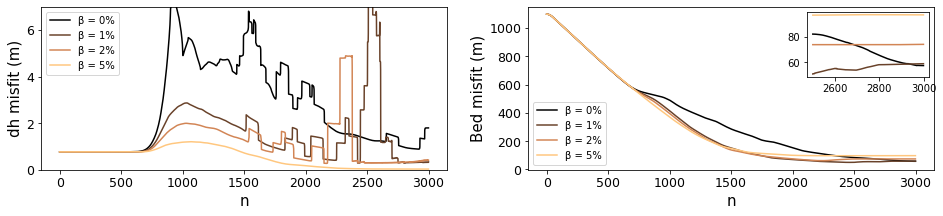

In [35]:
colors = plt.cm.copper(np.linspace(0,1,4))
fs = 15
fig, ax = plt.subplots(1,2, figsize=(16,3))
line1 = ax[0].plot(ndimage.convolve(dh_misfits[0], np.ones(100))/100, label='\u03B2 = 0%', color=colors[0])
line1 = ax[0].plot(ndimage.convolve(dh_misfits[1], np.ones(100))/100, label='\u03B2 = 1%', color=colors[1])
line1 = ax[0].plot(ndimage.convolve(dh_misfits[2], np.ones(100))/100, label='\u03B2 = 2%', color=colors[2])
line1 = ax[0].plot(ndimage.convolve(dh_misfits[3], np.ones(100))/100, label='\u03B2 = 5%', color=colors[3])
#line1 = ax[0].plot(ndimage.convolve(dh_misfits[4], np.ones(50))/50, label='5%')
#line1 = ax[0].plot(np.nanmean(abs(np.array(misfits[0])), axis=(1,2)))
ax[0].set_ylim([0,7])
ax[0].legend(loc=2)
line1 = ax[1].plot(ndimage.convolve(B_misfits[0], np.ones(100))/100, label='\u03B2 = 0%', color=colors[0])
line1 = ax[1].plot(ndimage.convolve(B_misfits[1], np.ones(100))/100, label='\u03B2 = 1%', color=colors[1])
line1 = ax[1].plot(ndimage.convolve(B_misfits[2], np.ones(100))/100, label='\u03B2 = 2%', color=colors[2])
line1 = ax[1].plot(ndimage.convolve(B_misfits[3], np.ones(100))/100, label='\u03B2 = 5%', color=colors[3])
#line1 = ax[1].plot(ndimage.convolve(B_misfits[4][1500:], np.ones(50))/50, label='5%')
ax[1].legend(loc=3)
ax[0].set_xlabel('n', fontsize=fs)
ax[1].set_xlabel('n', fontsize=fs)
ax[0].set_ylabel('dh misfit (m)', fontsize=fs)
ax[1].set_ylabel('Bed misfit (m)', fontsize=fs)
ax[0].tick_params(axis='both', which='major', labelsize=fs/1.2)
ax[1].tick_params(axis='both', which='major', labelsize=fs/1.2)

axins = inset_axes(ax[1], width="30%", height="40%", loc=1)
line1 = axins.plot(range(2500,3000), ndimage.convolve(B_misfits[0][-500:], np.ones(100))/100, label='0%', color=colors[0])
line1 = axins.plot(range(2500, 3000), ndimage.convolve(B_misfits[1][-500:], np.ones(100))/100, label='0%', color=colors[1])
line1 = axins.plot(range(2500, 3000), ndimage.convolve(B_misfits[2][-500:], np.ones(100))/100, label='0%', color=colors[2])
line1 = axins.plot(range(2500, 3000), ndimage.convolve(B_misfits[3][-500:], np.ones(100))/100, label='0%', color=colors[3])


plt.savefig('./figures/icecap_convergence.svg')

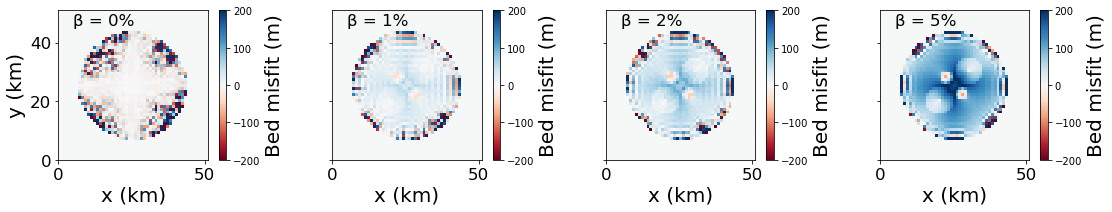

In [346]:
fs = 20
fig, ax = plt.subplots(1,4, figsize=(16,3), sharey=True)
labels = ['0%', '1%', '2%', '5%']
for q,i in enumerate(models[:-1]):
    #field3 = ax[q].pcolor(dh_all[i], vmin=-5, vmax=5, cmap='RdBu')
    field3 = ax[q].pcolor(B_recs[q] - topg, vmin=-200, vmax=200, cmap='RdBu')
    ax[q].set_aspect('equal', 'box')
    ax[q].text(.1, .9, '\u03B2 = {}'.format(labels[q]), transform = ax[q].transAxes, fontsize=fs/1.2)
    cbar3 = fig.colorbar(field3, ax = ax[q])
    cbar3.set_label('Bed misfit (m)', fontsize=fs)
    cbar3.ax.tick_params(axis='both', which='major', labelsize=ls)

    ax[q].set_xlabel('x (km)', fontsize=fs)
    ax[q].tick_params(axis='both', which='major', labelsize=fs/1.2)

    if q == 0:
        ax[q].set_ylabel('y (km)', fontsize=fs)

plt.tight_layout()
plt.savefig('./figures/beta_panel.png', dpi = 400)

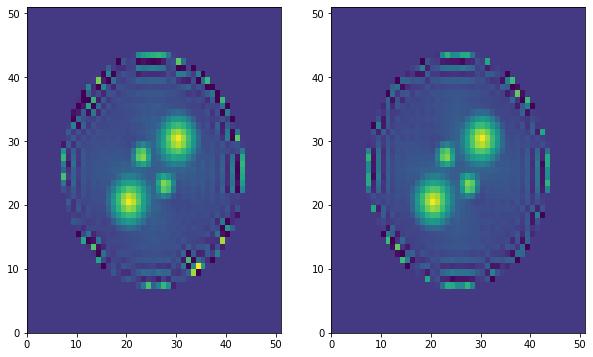

In [275]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
field = ax[0].pcolor(B_recs[2]-10000, vmin = -100, vmax=500)
field = ax[1].pcolor(B_recs[4]-10000, vmin = -100, vmax=500)

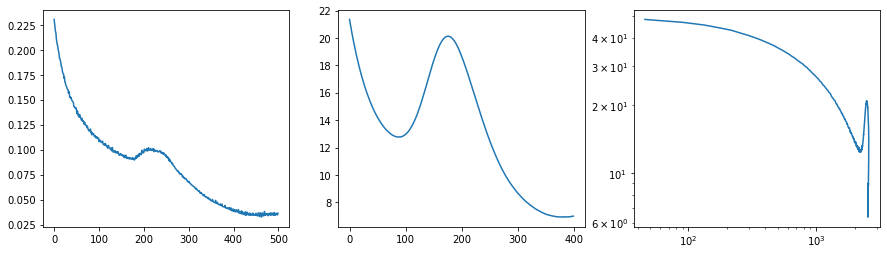

In [20]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
line1 = ax[0].plot(dh_misfit_vs_iter)
line2 = ax[1].plot(residual_norm_smooth[50:-50])
line3 = ax[2].loglog(model_norm, residual_norm)

In [183]:
    ## save output    
    import shelve
    bk = shelve.open('./it3000_beta1_dt.1_fromsurf_tosurf.05','n')
    for k in dir():
        if k in ['NPI_50m_DEM', 'NPI_DEM', 'NPI_DEM_o', 'R2_50m_Vel', 'R2_50m_Vx', 'R2_50m_Vy', 'R2_Vel', 'R2_Vx', 'R2_Vy', 'Z_09', 'Z_14', 'Z_50m_09', 'Z_50m_14', 'Z_50m_20', 'Z_50m_90', 'bed', 'bed_mask', 'bed_mask_meta', 'bed_o', 'dhdt_0914', 'dhdt_50m_0914', 'mat_DEM_Vel', 'mat_RADAR', 'ocean_50m_mask', 'retreat_50m_mask','smb_50m_fit', 'smb_fit', 'smb_net_0914', 'smb_net_df', 'smb_x', 'smb_y', 'smb_z', 'smb_xyz_df', 'surf', 'surf_mask','surf_mask_meta', 'surf_o', 'thk', 'thk_mask', 'thk_mask_meta', 'thk_o', 'vel_0914', 'vel_50m_0914', 'vel_df', 'vel_x', 'vel_y', 'vel_z', 'vel_xyz_df', 'x_50m', 'y_50m']:
            continue
        if k.split('_')[0]=='':
            continue
        try:
            bk[k] = globals()[k]
        except Exception:
            print('{} was not saved'.format(k))
            pass
    bk.close()

bk was not saved
copy was not saved
exit was not saved
f was not saved
get_ipython was not saved
getopt was not saved
math was not saved
nc was not saved
nc_updated was not saved
ndimage was not saved
np was not saved
original_stdout was not saved
plt was not saved
quit was not saved
shelve was not saved
spatial was not saved
subprocess was not saved
sys was not saved
tqdm was not saved
var was not saved


In [ ]:
save_and_commit('./icecap.ipynb', 'icecap', 'icecap_iteration_out.nc', 'file ready to be archieved')